In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from generateTrees import generate_random_tree, serialize, deserialize
from torch.utils.data import Dataset, DataLoader
import os

In [130]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

# Define the Transformer model

In [47]:

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        super(DecoderOnlyTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_layers = nn.TransformerDecoderLayer(d_model, nhead)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layers, num_layers)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        #print("x", x)
        #print("shape x", x.shape)
        x = self.embedding(x)
        #print("embedding", x.shape)
        memory = torch.zeros_like(x)
        output = self.transformer_decoder(x, memory)
        output = self.fc(output)
        return output

# Function for sequence generation

In [48]:
def generate_sequence(model, start_token, stop_token, max_length=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        current_token = torch.tensor([start_token])

        generated_sequence = [start_token]

        # Generate sequences until the stop token is encountered or reach max length
        for _ in range(max_length):
            logits = model(current_token.unsqueeze(0))  # Add batch dimension
            

            # Sample the next token using argmax
            next_token = torch.argmax(logits[:, -1, :]).item()
            # Append the next token to the generated sequence
            generated_sequence.append(next_token)

            # If the stop token is encountered, break the loop
            if next_token == stop_token:
                break

            # Update the current token for the next iteration
            current_token = torch.tensor([next_token])

        return generated_sequence

# Data Loader

In [49]:
def read_tree(filename, dir):
    with open(dir +'/' +filename, "r") as f:
        byte = f.read() 
        return byte

In [83]:
def my_collate(batch):
    return batch


class tDataset(Dataset):
    def __init__(self, l, dir, transform=None):
        self.names = l
        self.transform = transform
        self.data = [] #lista con las strings de todos los arboles
        for file in self.names:
            self.data.append(read_tree(file, dir))

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        tree = self.data[idx]
        tree = tree.split(';')
        tree = [int(item) for item in tree]
        tree = torch.tensor(tree)
        return tree

batch_size = 1

# Training

In [156]:
vocab_size = 100
model = DecoderOnlyTransformer(vocab_size=vocab_size, d_model=256, nhead=4, num_layers=3)


# Loss function and optimizer

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with batches
num_epochs = 500
losses = []

folder = "trees"
t_list = os.listdir( folder)[:1]
dataset = tDataset(t_list, folder )
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)


# Count the occurrences of each class
input = next(iter(data_loader))[0].tolist()
vocab_classes = set(range(vocab_size))
#print("input", input)
class_counts = dict(zip(*np.unique(input, return_counts=True)))
# Add missing classes from the vocabulary with zero occurrences
vocab_classes = set(range(vocab_size))
for cls in vocab_classes - set(class_counts.keys()):
    class_counts[cls] = 0

ordered_counts = dict(sorted(class_counts.items()))
total_samples = len(input)
class_frequencies = {cls: 1 / count if count != 0 else 0 for cls, count in ordered_counts.items()}


class_weights_tensor = torch.tensor([class_frequencies[cls] for cls in range(len(class_frequencies))], dtype=torch.float32)
mult = torch.tensor([1/round(5),1/round(2),1/round(3)])

#print("weights", class_weights_tensor)
#print("mult", mult)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

for epoch in range(num_epochs):
    loss_batch = []
    for batch_idx, batch in enumerate(data_loader):
        #print("batch", batch)
        optimizer.zero_grad()
        max_seq_length = max(len(seq) for seq in batch)
        padded_batch = [torch.nn.functional.pad(seq, pad=(0, max_seq_length - len(seq))) for seq in batch]
        input_sequence = [lst[:-1] for lst in padded_batch]
        target_sequence = [lst[1:] for lst in padded_batch]

        # Forward pass
        ##padding para que las secuencias tengan el mismo largo
        outputs = model(torch.stack(input_sequence))
        '''
        for i in range(batch_size):
            predicted_tokens = torch.argmax(outputs[i], dim=-1).tolist()
            print(f"Batch {batch_idx + 1}, Sequence {i + 1} - Predicted tokens: {predicted_tokens}")
            for j in range(len(predicted_tokens)):
                print("token en la sequencia original - token que predijo", target_sequence[i][j].item(), predicted_tokens[j])'''

        # Calculate the loss using the shifted target sequence
        loss = criterion(outputs.view(-1, outputs.size(-1)), torch.cat(target_sequence))
        loss.backward()
        optimizer.step()
        loss_batch.append(loss.item())
    losses.append(np.average(loss_batch))
    if (epoch) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.average(loss_batch)}')



Epoch [1/500], Loss: 4.733096599578857
Epoch [6/500], Loss: 1.6829800605773926
Epoch [11/500], Loss: 1.1884506940841675
Epoch [16/500], Loss: 1.057334542274475
Epoch [21/500], Loss: 1.0292863845825195
Epoch [26/500], Loss: 1.1998032331466675
Epoch [31/500], Loss: 1.1205837726593018
Epoch [36/500], Loss: 1.1901538372039795
Epoch [41/500], Loss: 1.4190853834152222
Epoch [46/500], Loss: 1.0904301404953003
Epoch [51/500], Loss: 1.1351103782653809
Epoch [56/500], Loss: 1.1282031536102295
Epoch [61/500], Loss: 1.2178326845169067
Epoch [66/500], Loss: 1.3601503372192383
Epoch [71/500], Loss: 1.091884732246399


KeyboardInterrupt: 

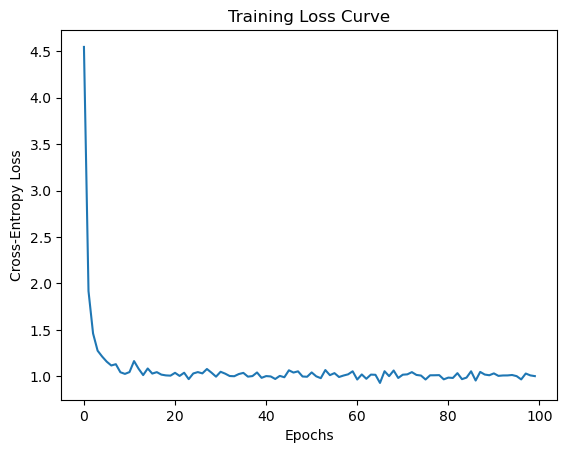

Generated Sequence:
[85, 97, 99, 34, 39, 99, 34, 39, 99, 34, 39]


In [153]:
# Plotting the loss curve
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss Curve')
plt.show()

# Choose a starting token and stop token for generation
start_token = torch.randint(0, vocab_size, (1,))
stop_token = torch.randint(0, vocab_size, (1,))

# Generate a sequence using autoregressive sampling
generated_sequence = generate_sequence(model, start_token.item(), stop_token.item(), max_length=10)


# Print the generated sequence
print("Generated Sequence:")
print(generated_sequence)

In [ ]:
99;99;39;99;99;22;7;99;99;39;99;99;26;41;98;99;99;43;99;99;34;39;99;99;62;30;97